In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.17.0


#***1.Importing the CIFAR10 set***












In [ ]:
# Load in the data
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(train_imgs, train_labels), (test_imgs, test_labels) = cifar10.load_data()


print(train_imgs.shape, train_labels.shape, test_imgs.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#***2.Visualizing the dataset***



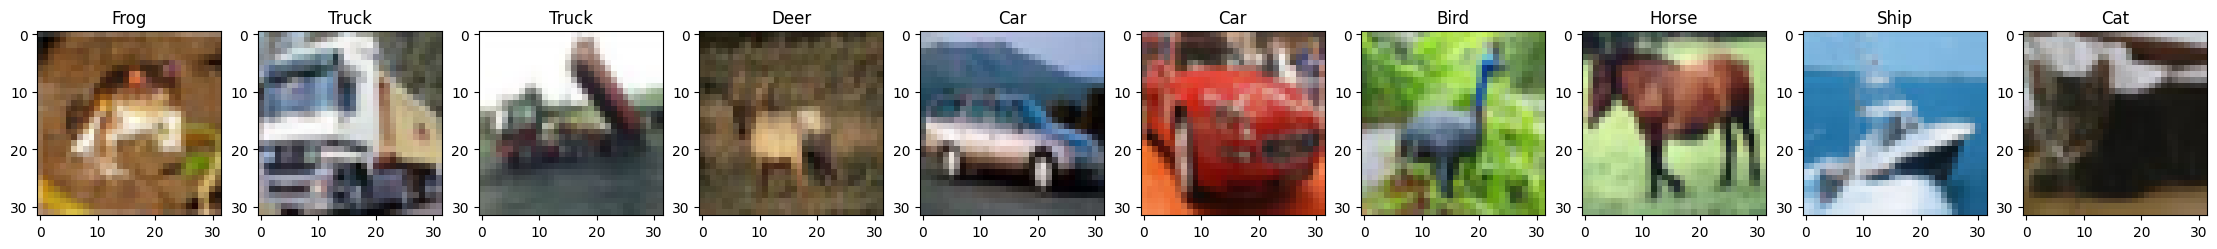

In [ ]:

class_names = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
fig, axes = plt.subplots(1,10,figsize=(28,28))

for i in range(10):
    axes[i].imshow(train_imgs[i], cmap='binary')
    axes[i].set_title(class_names[train_labels[i][0]])


# ***3.Preparing the data***

In [ ]:
# Reduce pixel values
train_imgs, test_imgs = train_imgs / 255.0, test_imgs / 255.0
img_rows, img_cols , channels= 32,32,3
# Flatten the label values
train_labels, test_labels = train_labels.flatten(), test_labels.flatten()
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(train_imgs)

train_imgs = train_imgs.reshape(train_imgs.shape[0], img_rows, img_cols, channels)
test_imgs = test_imgs.reshape(test_imgs.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('train_imgs shape:', train_imgs.shape)
print(train_imgs.shape[0], 'train samples')
print(test_imgs.shape[0], 'test samples')

# Convert integers to float; Normalize and center the mean
train_imgs=train_imgs.astype("float32")
test_imgs=test_imgs.astype("float32")
mean=np.mean(train_imgs)
std=np.std(train_imgs)
test_imgs=(test_imgs-mean)/std
train_imgs=(train_imgs-mean)/std
# labels
num_classes=10

train_imgs shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# ***4.CNN training and prediction***

##**4.1 CNN Model Structure**


In [ ]:
def create_model():

 # Input layer
 i = Input(shape=train_imgs[0].shape)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
 x = BatchNormalization()(x)
 x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 x = BatchNormalization()(x)
 x = MaxPooling2D((2, 2))(x)

 x = Flatten()(x)
 x = Dropout(0.5)(x) #Neuron dropout to stop overfitting

# Hidden layer
 x = Dense(1024, activation='relu')(x)
 x = Dropout(0.5)(x)

# Output layer
 x = Dense(10, activation='softmax')(x)

 model = Model(i, x)
 return model


In [ ]:
model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## **4.2 Model Summary**

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_72 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_73 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_73 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0   

## **4.3 TPU Setup**

In [ ]:
import os
import tensorflow as tf

try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', resolver.master())
except ValueError:
  print('Not connected to a TPU runtime. Using CPU/GPU instead.')
  resolver = None # Explicitly set resolver to None if TPU not found


if resolver:
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.experimental.TPUStrategy(resolver)
    print("All devices: ", tf.config.list_logical_devices('TPU'))
else:
    # Code to run if TPU is not available (e.g., using CPU or GPU)
    strategy = tf.distribute.get_strategy() # Default strategy for CPU/GPU
    print("All devices: ", tf.config.list_logical_devices())

Running on TPU  


All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


### **4.4 TPU Compilation and Training**

In [ ]:
with strategy.scope():
  model = create_model()
  model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

network = model.fit(
    train_imgs.astype(np.float32), train_labels.astype(np.float32),
    shuffle=True,
    epochs=50,
    steps_per_epoch=60,
    validation_data=(test_imgs.astype(np.float32), test_labels.astype(np.float32)),
    validation_freq=10
)

model.save_weights('./cifar10_weights.h5', overwrite=True)

Epoch 1/50
60/60 [==============================] - 6s 24ms/step - loss: 2.2630 - accuracy: 0.3437
Epoch 2/50
60/60 [==============================] - 1s 24ms/step - loss: 1.3893 - accuracy: 0.4946
Epoch 3/50
60/60 [==============================] - 1s 23ms/step - loss: 1.1971 - accuracy: 0.5691
Epoch 4/50
60/60 [==============================] - 1s 23ms/step - loss: 1.0424 - accuracy: 0.6246
Epoch 5/50
60/60 [==============================] - 1s 23ms/step - loss: 0.9349 - accuracy: 0.6660
Epoch 6/50
60/60 [==============================] - 1s 23ms/step - loss: 0.8449 - accuracy: 0.6976
Epoch 7/50
60/60 [==============================] - 1s 23ms/step - loss: 0.7820 - accuracy: 0.7242
Epoch 8/50
60/60 [==============================] - 1s 23ms/step - loss: 0.7156 - accuracy: 0.7445
Epoch 9/50
60/60 [==============================] - 1s 24ms/step - loss: 0.6575 - accuracy: 0.7676
Epoch 10/50
60/60 [==============================] - 5s 90ms/step - loss: 0.6084 - accuracy: 0.7845 - val_los

## **4.5 Model Evaluation**

In [ ]:
train_acc = model.evaluate(test_imgs,test_labels,batch_size=128)

print(f"Accuracy:{train_acc}")

79/79 [==============================] - 2s 9ms/step - loss: 0.7238 - accuracy: 0.8203
Accuracy:[0.7238179445266724, 0.8202999830245972]


## **4.5 Loss & Accuracy Visualization**

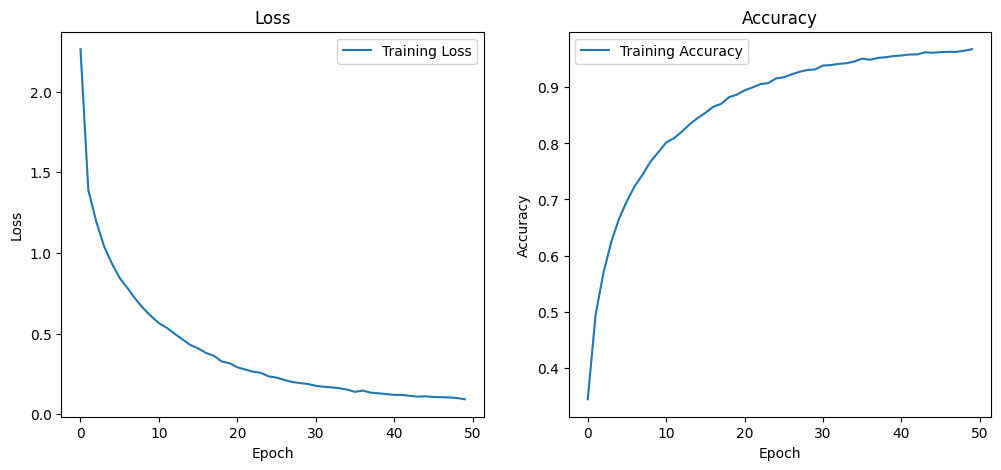

In [ ]:
# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(network.history['loss'], label='Training Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(network.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()


## **4.6 Prediction sample**

1/1 [==============================] - 1s 1s/step
Original label is Horse and predicted label is Horse


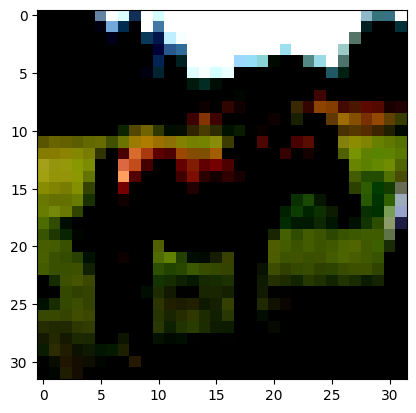

In [ ]:
# label mapping

labels = '''Plane Car Bird Cat Deer Dog Frog Horse Ship Truck'''.split()

# select the image from our test dataset
image_number = 9999

plt.imshow(test_imgs[image_number])
n = np.array(test_imgs[image_number])
p = n.reshape(1, 32, 32, 3)
# pass in the network for prediction and
predicted_label = labels[model.predict(p).argmax()]
original_label = labels[test_labels[image_number]]

print("Original label is {} and predicted label is {}".format(
	original_label, predicted_label))


# ***5.ResNet-18 Training and Prediction***

## **5.1 Res-18 Model & Summary**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, stride=1, downsample=False):
    shortcut = x

    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Downsample the shortcut connection if necessary
    if downsample:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut connection
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x


def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # Initial convolution and max-pooling layer
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # CIFAR-10 图像较小，因此可以省略初始的 max-pooling 层

    # Residual layers
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, downsample=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, downsample=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, downsample=True)
    x = residual_block(x, 512)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = models.Model(inputs, outputs)
    return model

# Instantiate and compile the model
resnet18 = build_resnet18(input_shape=(32, 32, 3), num_classes=10)
resnet18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
resnet18.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,728 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 32, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,864 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 11,183,562 (42.66 MB)

 Trainable params: 11,173,962 (42.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

## **5.2 Reload the set and Preparing**

In [ ]:
# 导入 CIFAR-10 数据集
(train_imgs, train_labels), (test_imgs, test_labels) = tf.keras.datasets.cifar10.load_data()

# 数据预处理
# 将图像像素值归一化到 [0, 1] 范围
train_imgs = train_imgs.astype('float32') / 255.0
test_imgs = test_imgs.astype('float32') / 255.0

# 将标签转换为独热编码格式
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)



170498071/170498071 [==============================] - 2s 0us/step


## **5.3 Model Training**

In [ ]:
# 创建 ResNet-18 模型
resnet18 = build_resnet18(input_shape=(32, 32, 3), num_classes=10)

# 编译模型
resnet18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = resnet18.fit(
    train_imgs,
    train_labels,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(test_imgs, test_labels),
    validation_freq=5
)


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 74s 128ms/step - accuracy: 0.4502 - loss: 1.5737
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 99ms/step - accuracy: 0.7294 - loss: 0.7742
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.8111 - loss: 0.5427
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - accuracy: 0.8605 - loss: 0.4035
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 113ms/step - accuracy: 0.8976 - loss: 0.2917 - val_accuracy: 0.7078 - val_loss: 0.9873
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 76s 99ms/step - accuracy: 0.9213 - loss: 0.2202
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.9462 - loss: 0.1531
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9574 - loss: 0.1205
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - accuracy: 0.9675 - loss: 0.0952
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 105ms/step - accuracy: 0.9739 - loss: 0.0749 - val_accuracy: 0.8075 - val_loss: 0.8166
Epoch 11/100
391/391 ━

ValueError: The filename must end in `.weights.h5`. Received: filepath=./cifar10_resnet18_weights.h5

In [ ]:
# 保存模型权重，文件名为 .weights.h5
resnet18.save_weights('./cifar10_resnet18.weights.h5', overwrite=True)


## **5.4 Model Evaluation**

In [ ]:
train_acc = resnet18.evaluate(test_imgs,test_labels,batch_size=128)

print(f"Accuracy:{train_acc}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8352 - loss: 1.2385
Accuracy:[1.2029410600662231, 0.8389999866485596]


## **5.5 Loss & Accuracy visualization**

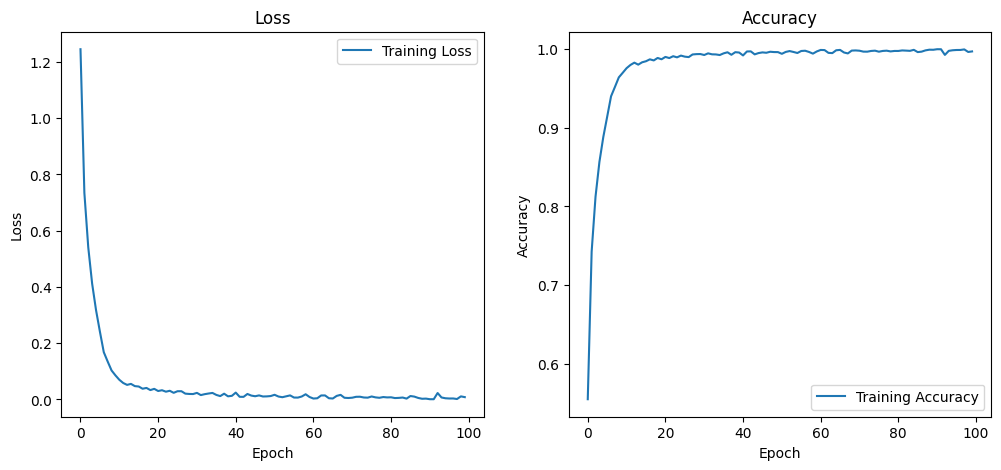

In [ ]:
# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

## ***6.AlexNet model***

### **6.1 AlexNet Model & Summary**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_simple_alexnet(input_shape=(32, 32, 3), n_classes=10):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(n_classes, activation='softmax'))

    return model

# 构建简化版的 AlexNet 模型
input_shape = (32, 32, 3)  # CIFAR-10 的输入尺寸
n_classes = 10  # CIFAR-10 有 10 个类别

model = build_simple_alexnet(input_shape, n_classes)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 假设您有 CIFAR-10 数据 (x_train, y_train) 和 (x_test, y_test)
# model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


In [ ]:

# 训练模型
history = model.fit(train_imgs, train_labels, epochs=10, batch_size=32, validation_data=(test_imgs, test_labels))


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-10-826f922b762b>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_1484]

In [ ]:
# 可视化训练过程（损失和准确率）
import matplotlib.pyplot as plt

# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()
